In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/219-DataMining/Project3/

/content/drive/.shortcut-targets-by-id/16hjVMa-Uf3Wt_XxP2oCwY8fwquaEFqtB/Project3


# IMPORTS

In [ ]:
!pip install Surprise

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import collections

from surprise import accuracy   
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import KFold
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.prediction_algorithms.matrix_factorization import NMF, SVD
from surprise.model_selection import train_test_split

from sklearn.metrics import  roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

%matplotlib inline

# QUESTION 1

In [ ]:
df = pd.read_csv("./Dataset/ratings.csv")

In [ ]:
df.size, df.shape

(504180, (100836, 5))

In [ ]:
df.tail(5)

,Unnamed: 0,userId,movieId,rating,timestamp
100831,100831,469,1219,4.0,965661925
100832,100832,599,3571,2.0,1498511343
100833,100833,414,276,3.0,961596299
100834,100834,395,168,3.0,841503984
100835,100835,288,2407,3.5,1054568795


A

In [ ]:
user_ID = df["userId"].values
movie_ID = df["movieId"].values
rating = df["rating"].values

In [ ]:
sparsity = rating.shape[0] / (len(set(user_ID)) * len(set(movie_ID)))
print(sparsity)

0.016999683055613623


In [ ]:
print(len(set(rating)))

10


The ratings column has values starting at 0.5 upto 5 in steps of 0.5

B

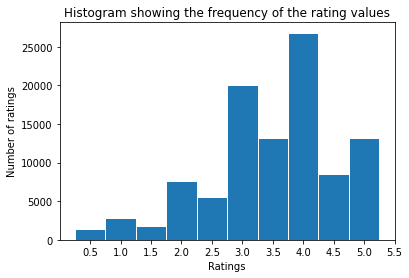

In [ ]:
bins = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5]
plt.hist(rating, bins=bins, edgecolor="white", align="left")
plt.gca().set_xticks(bins)
plt.xlabel("Ratings")
plt.ylabel("Number of ratings")
plt.title("Histogram showing the frequency of the rating values")
plt.show()

In [ ]:
print(len(set(movie_ID)))

9724


C

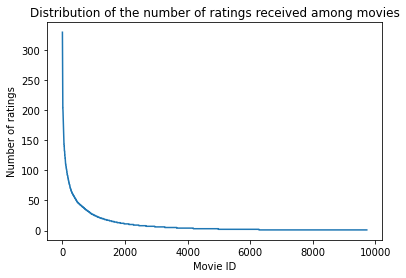

In [ ]:
movies, movies_count = np.unique(movie_ID, return_counts=True)
plt.plot(range(1, len(set(movie_ID)) + 1), movies_count[np.argsort(movies_count)[::-1]])
plt.xlabel("Movie ID")
plt.ylabel("Number of ratings")
plt.title("Distribution of the number of ratings received among movies")
plt.show()

In [ ]:
print(len(set(user_ID)))

610


D

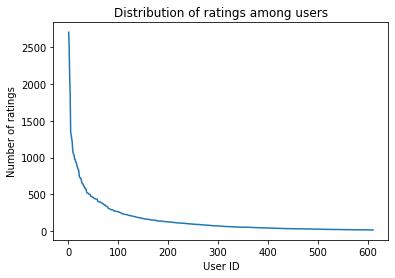

In [ ]:
users, users_count = np.unique(user_ID, return_counts=True)
plt.plot(range(1, len(set(user_ID)) + 1), users_count[np.argsort(users_count)[::-1]])
plt.xlabel("User ID")
plt.ylabel("Number of ratings")
plt.title("Distribution of ratings among users")
plt.show()

F

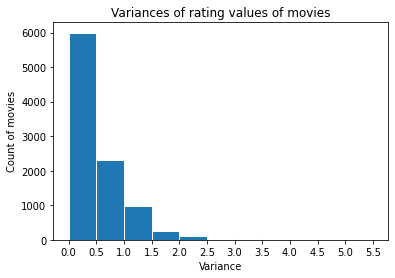

In [ ]:
movie_to_ratings = collections.defaultdict(list)
variances = list()

for i in range(len(movie_ID)):
    movie_to_ratings[movie_ID[i]].append(rating[i])

for l in movie_to_ratings.values():
    variances.append(np.var(l))

bins = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4.0, 4.5, 5.0, 5.5]
plt.hist(variances, bins=bins, edgecolor="white")
plt.gca().set_xticks(bins)
plt.xlabel("Variance")
plt.ylabel("Count of movies")
plt.title("Variances of rating values of movies")
plt.show()

## QUESTION 4-6

In [ ]:
def process_movie(test_input, freq, high_var=None, data_filter='popular'):
    if data_filter == 'popular' or data_filter == 'unpopular':
        if data_filter == 'popular':
            catogory = list(freq.where(freq > 2).dropna().keys())
        elif data_filter == 'unpopular':
            catogory = list(freq.where(freq <= 2).dropna().keys())
        res = []
        for i in range(len(test_input)):
            if int(test_input[i][1]) in catogory:
                res.append(test_input[i])
    elif data_filter == 'high_variance':
        catogory = list(freq.where(freq >=5).dropna().keys())
        high_var_catogory = list(high_var.where(high_var >=2).dropna().keys())
        res = []
        for i in range(len(test_input)):
            if int(test_input[i][1]) in catogory and int(test_input[i][1]) in high_var_catogory:
                res.append(test_input[i])
    return res

In [ ]:
def cross_validation_KNN(training_input, freq=None, high_var=None, data_filter='original', title='None', x_label='None', y_label='None'):
    kfold_model = KFold(n_splits=10)
    RMSE = []
    MAE = []
    for k in range(2, 102, 2):
        knn_model = KNNWithMeans(k=k, sim_options={'name': 'pearson'}, verbose=False)
        rmse_temp = []
        mae_temp = []
        for training_data, val_data in kfold_model.split(training_input):
            knn_model.fit(training_data)
            if data_filter == 'original':
                processed_data = val_data
            elif data_filter == 'popular' or data_filter == 'unpopular':
                processed_data = process_movie(val_data, freq, data_filter=data_filter)
            else: # 'high_variance'
                processed_data = process_movie(val_data, freq, high_var=high_var, data_filter=data_filter)
            res = knn_model.test(processed_data)
            rmse_temp.append(accuracy.rmse(res, verbose=False))
            mae_temp.append(accuracy.mae(res, verbose=False))
        rmse_mean = np.mean(rmse_temp)
        mae_mean = np.mean(mae_temp)
        RMSE.append(rmse_mean)
        MAE.append(mae_mean)
    print("Average RMSE")
    plt.plot(np.arange(2, 102, 2), RMSE)
    plt.title("RMSE " + title)
    plt.xlabel(x_label)
    plt.ylabel("RMSE " + y_label)
    plt.show()
    print("---" * 20)
    print("Average MAE")
    plt.plot(np.arange(2, 102, 2), MAE)
    plt.title("MAE " + title)
    plt.xlabel(x_label)
    plt.ylabel("MAE " + y_label)
    plt.show()
    return RMSE, MAE

In [ ]:
# def find_min_k(RMSE, MAE=None, data_filter='original'):
#     for i in range(1, len(RMSE) - 1):
#         if((abs(RMSE[i] - RMSE[i+1]) < 5e-4)):
#             k = 2 * i
#             print("Minimum k: ", k)
#             print("RMSE: ", RMSE[i])
#             if data_filter == 'original':
#                 print("MAE: ", MAE[i])
#             break
#     k = 2 * i
#     print("Minimum k: ", k)
#     print("RMSE: ", RMSE[i])
#     if data_filter == 'original':
#         print("MAE: ", MAE[i])
#     return k

In [ ]:
def find_min_k_RMSE(RMSE, k):
    optimal_k = 0
    for i, x in enumerate(RMSE):
        if x == min(RMSE):
            optimal_k = k[i]
    return optimal_k, min(RMSE)

In [ ]:
def find_min_k_MAE(MAE, k):
    optimal_k = 0
    for i, x in enumerate(MAE):
        if x == min(MAE):
            optimal_k = k[i]
    return optimal_k, min(MAE)

In [ ]:
ratings_data = Dataset.load_from_df(df[['userId','movieId','rating']], Reader(rating_scale=(0.5, 5)))

Average RMSE


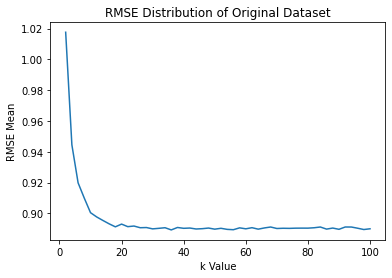

------------------------------------------------------------
Average MAE


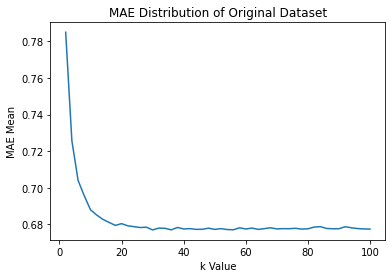

In [ ]:
RMSE_original, MAE_original = cross_validation_KNN(ratings_data, data_filter='original', title='Distribution of Original Dataset', x_label='k Value', y_label='Mean')

In [ ]:
print(RMSE_original[11])
print(MAE_original[11])

0.891701710870428
0.6788015737863852


In [ ]:
find_min_k_RMSE(RMSE_original, list(range(2, 102, 2)))

(40, 0.8886256858005016)

In [ ]:
find_min_k_MAE(MAE_original, list(range(2, 102, 2)))

(40, 0.6765798553169977)

POPULAR

In [ ]:
freq = np.sum((df.pivot_table('rating', 'userId', 'movieId', fill_value=0))!=0, axis=0)

Average RMSE


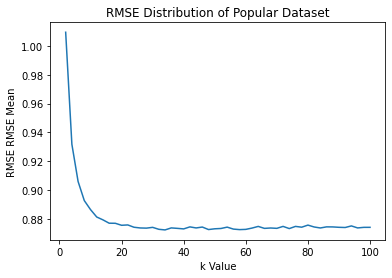

------------------------------------------------------------
Average MAE


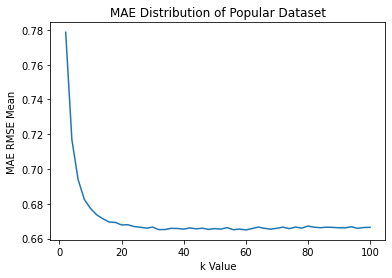

In [ ]:
RMSE_popular, _ = cross_validation_KNN(ratings_data, freq=freq, data_filter='popular', title='Distribution of Popular Dataset', x_label='k Value', y_label='RMSE Mean')

In [ ]:
find_min_k_RMSE(RMSE_popular, list(range(2, 102, 2)))

(38, 0.8726274884946378)

UNPOPULAR

Average RMSE


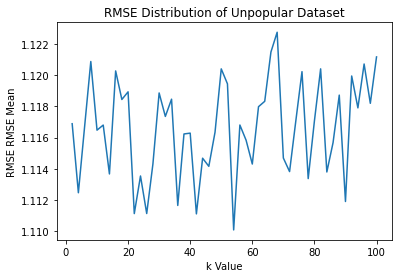

------------------------------------------------------------
Average MAE


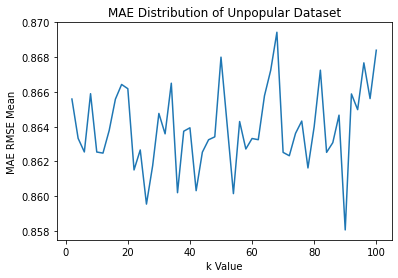

In [ ]:
RMSE_unpopular, _ = cross_validation_KNN(ratings_data, freq=freq, data_filter='unpopular', title='Distribution of Unpopular Dataset', x_label='k Value', y_label='RMSE Mean')

In [ ]:
find_min_k_RMSE(RMSE_unpopular, list(range(2, 102, 2)))

(54, 1.1100706620405247)

In [ ]:
high_var = np.var((df.pivot_table('rating', 'userId', 'movieId')), axis=0)

Average RMSE


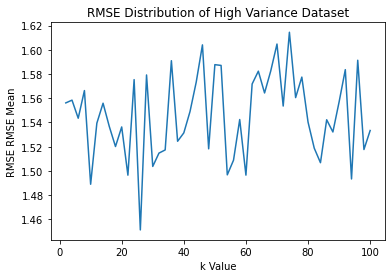

------------------------------------------------------------
Average MAE


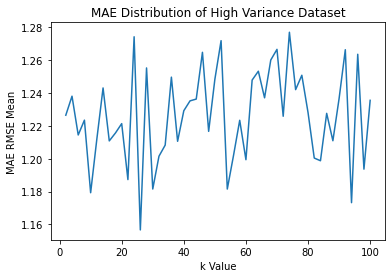

In [ ]:

RMSE_high_var, _ = cross_validation_KNN(ratings_data, freq=freq, high_var=high_var, data_filter='high_variance', title='Distribution of High Variance Dataset', x_label='k Value', y_label='RMSE Mean')

In [ ]:
find_min_k_RMSE(RMSE_high_var, list(range(2, 102, 2)))

(26, 1.4513083692903592)

## ROC CURVE FOR KNN


In [ ]:
def plot_roc_knn(dataset, k, threshold, freq, high_var=None, data_filter='original'):
    knn_model = KNNWithMeans(k=k, sim_options={'name': 'pearson'}, verbose=False)
    train, test = train_test_split(dataset, test_size=0.1)
    knn_model.fit(train)
    if data_filter == 'original':
        test = test
    elif data_filter == 'popular' or data_filter == 'unpopular':
        test = process_movie(test, freq, data_filter=data_filter)
    else: # 'high_variance'
        test = process_movie(test, freq, high_var=high_var, data_filter=data_filter)
    prediction = knn_model.test(test)
    label = []
    pred = []
    for i in range(len(prediction)):
        pred.append(prediction[i].est)
        if test[i][2] >= threshold:
            label.append(1)
        else:
            label.append(0)
    fpr, tpr, _ = roc_curve(label, pred)
    AUC = roc_auc_score(label, pred)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive')
    plt.ylabel('True Positive')
    plt.title('ROC Curve of Threshold {} and AUC {}'.format(threshold, AUC))
    plt.show()
    return fpr, tpr, AUC

In [ ]:
ratings_data = Dataset.load_from_df(df[['userId','movieId','rating']], Reader(rating_scale=(0.5, 5.5)))

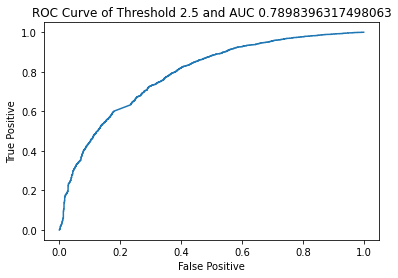

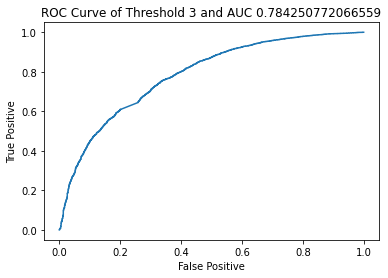

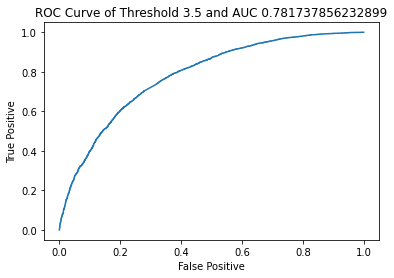

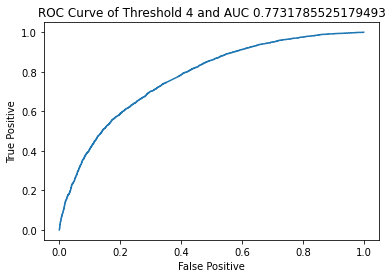

In [ ]:
thresholds = [2.5, 3, 3.5, 4]
fprs = []
tprs = []
AUCs = []
min_k = 20
for threshold in thresholds:
    fpr, tpr, AUC = plot_roc_knn(ratings_data, min_k, threshold, freq=freq, high_var=high_var, data_filter='original')
    fprs.append(fpr)
    tprs.append(tpr)
    AUCs.append(AUC)

In [ ]:
def comparison_plot_knn(fprs, tprs, AUCs, thresholds, title='Original'):
    for i in range(len(fprs)):
        plt.plot(fprs[i], tprs[i], label = 'ROC Curve of Threshold {} and AUC {:.5f}'.format(thresholds[i], AUCs[i]))
    plt.legend()
    plt.xlabel('False Positive')
    plt.ylabel('True Positive')
    plt.title('ROC Curve for Comparison with {} Dataset'.format(title))
    plt.show()

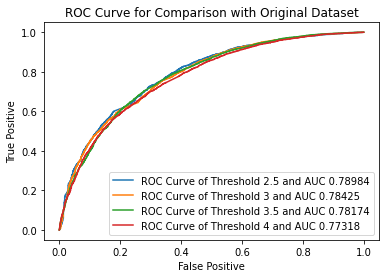

In [ ]:
comparison_plot_knn(fprs, tprs, AUCs, thresholds, title='Original')

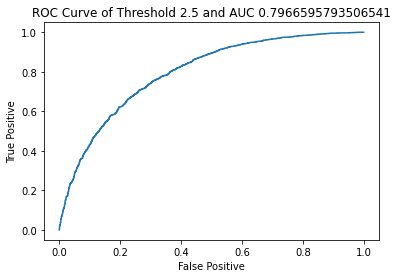

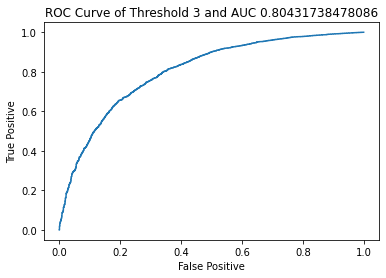

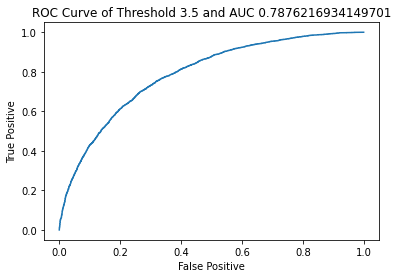

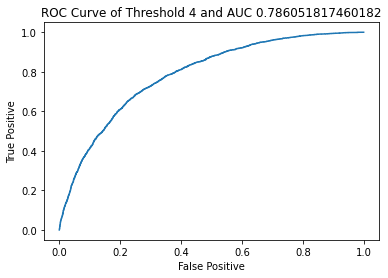

In [ ]:
fprs_pop = []
tprs_pop = []
AUCs_pop = []
min_k = 38
for threshold in thresholds:
    fpr, tpr, AUC = plot_roc_knn(ratings_data, min_k, threshold, freq=freq, high_var=high_var, data_filter='popular')
    fprs_pop.append(fpr)
    tprs_pop.append(tpr)
    AUCs_pop.append(AUC)

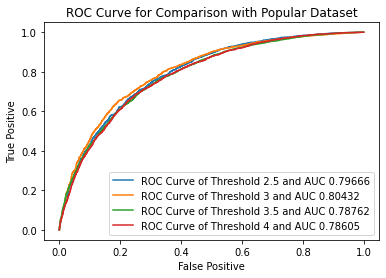

In [ ]:
comparison_plot_knn(fprs_pop, tprs_pop, AUCs_pop, thresholds, title='Popular')

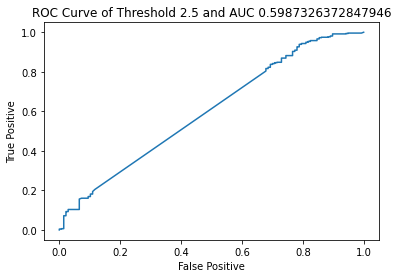

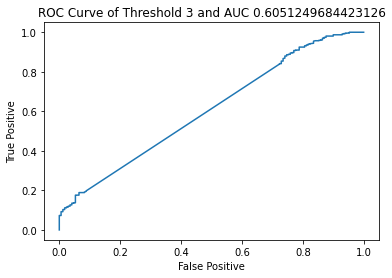

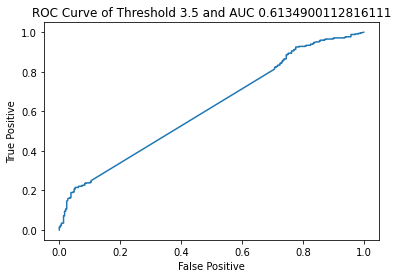

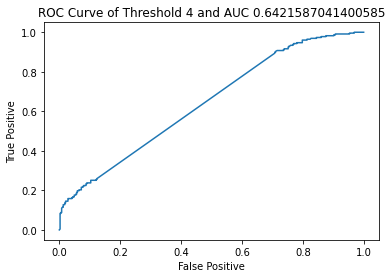

In [ ]:
fprs_unpop = []
tprs_unpop = []
AUCs_unpop = []
min_k = 54
for threshold in thresholds:
    fpr, tpr, AUC = plot_roc_knn(ratings_data, min_k, threshold, freq=freq, high_var=high_var, data_filter='unpopular')
    fprs_unpop.append(fpr)
    tprs_unpop.append(tpr)
    AUCs_unpop.append(AUC)

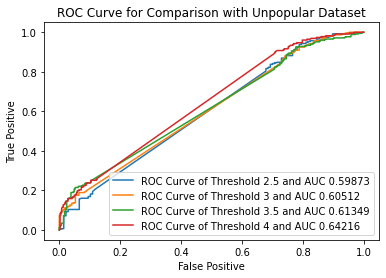

In [ ]:
comparison_plot_knn(fprs_unpop, tprs_unpop, AUCs_unpop, thresholds, title='Unpopular')

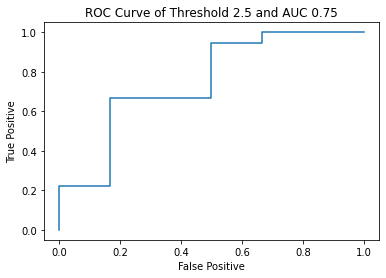

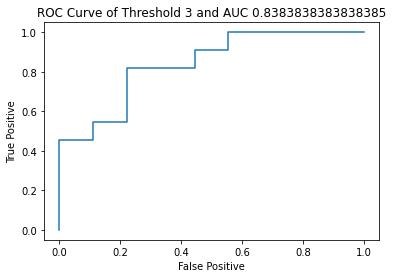

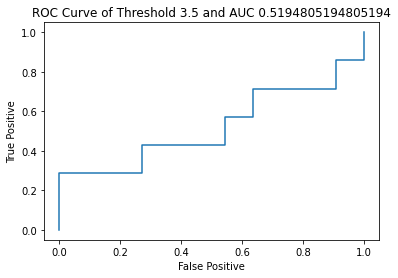

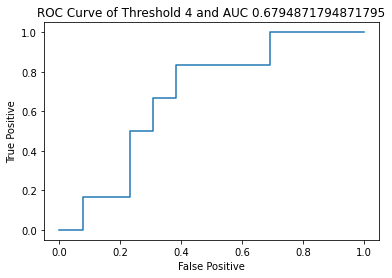

In [ ]:
fprs_var = []
tprs_var = []
AUCs_var = []
min_k = 26
for threshold in thresholds:
    fpr, tpr, AUC = plot_roc_knn(ratings_data, min_k, threshold, freq=freq, high_var=high_var, data_filter='high_variance')
    fprs_var.append(fpr)
    tprs_var.append(tpr)
    AUCs_var.append(AUC)

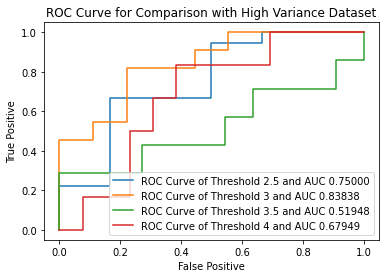

In [ ]:
comparison_plot_knn(fprs_var, tprs_var, AUCs_var, thresholds, title='High Variance')

# QUESTION 8

In [ ]:
def cross_validation_NMF(training_input, freq=None, high_var=None, data_filter='original', title='None', x_label='None', y_label='None'):
    kfold_model = KFold(n_splits=10)
    RMSE = []
    MAE = []
    for n_factors in range(2, 52, 2):
        nmf_model = NMF(n_factors=n_factors, verbose=False)
        rmse_temp = []
        mae_temp = []
        for training_data, val_data in kfold_model.split(training_input):
            nmf_model.fit(training_data)
            if data_filter == 'original':
                processed_data = val_data
            elif data_filter == 'popular' or data_filter == 'unpopular':
                processed_data = process_movie(val_data, freq, data_filter=data_filter)
            else: # 'high_variance'
                processed_data = process_movie(val_data, freq, high_var=high_var, data_filter=data_filter)
            res = nmf_model.test(processed_data)
            rmse_temp.append(accuracy.rmse(res, verbose=False))
            mae_temp.append(accuracy.mae(res, verbose=False))
        rmse_mean = np.mean(rmse_temp)
        mae_mean = np.mean(mae_temp)
        RMSE.append(rmse_mean)
        MAE.append(mae_mean)
    print("Average RMSE")
    plt.plot(np.arange(2, 52, 2), RMSE)
    plt.title("RMSE " + title)
    plt.xlabel(x_label)
    plt.ylabel("RMSE " + y_label)
    plt.show()
    print("---" * 20)
    print("Average MAE")
    plt.plot(np.arange(2, 52, 2), MAE)
    plt.title("MAE " + title)
    plt.xlabel(x_label)
    plt.ylabel("MAE " + y_label)
    plt.show()
    return RMSE, MAE

Average RMSE


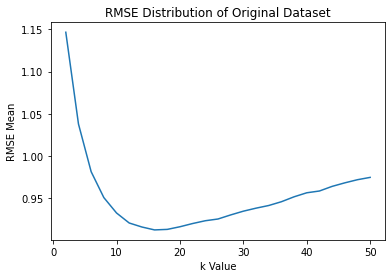

------------------------------------------------------------
Average MAE


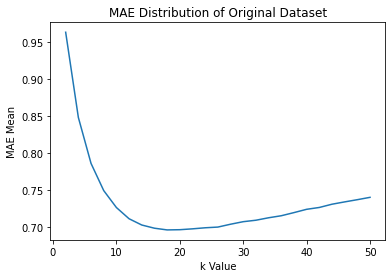

In [ ]:
ratings_data = Dataset.load_from_df(df[['userId','movieId','rating']], Reader(rating_scale=(0.5, 5.5)))
NMF_RMSE_original, NMF_MAE_original = cross_validation_NMF(ratings_data, data_filter='original', title='Distribution of Original Dataset', x_label='k Value', y_label='Mean')

In [ ]:
optimal_k, rmse = find_min_k_RMSE(NMF_RMSE_original, list(range(2, 52, 2)))
print("RMSE = {:.4f} and k = {}".format(rmse, optimal_k))

RMSE = 0.9127 and k = 16


In [ ]:
optimal_k, mae = find_min_k_MAE(NMF_MAE_original, list(range(2, 52, 2)))
print("MAE = {:.4f} and k = {}".format(mae, optimal_k))

MAE = 0.6962 and k = 18


GENRES

In [ ]:
s = set()
d = pd.read_csv("./Dataset/movies.csv")
genres = d["genres"].values
for entry in genres:
    genres_list = entry.split("|")
    for val in genres_list:
        s.add(val)

In [ ]:
print(len(s))

20


In [ ]:
print(s)

{'IMAX', 'Musical', 'Mystery', 'War', 'Film-Noir', 'Sci-Fi', 'Animation', 'Western', 'Drama', 'Children', 'Documentary', 'Fantasy', 'Thriller', 'Comedy', 'Action', 'Crime', 'Horror', 'Adventure', '(no genres listed)', 'Romance'}


POPULAR

Average RMSE


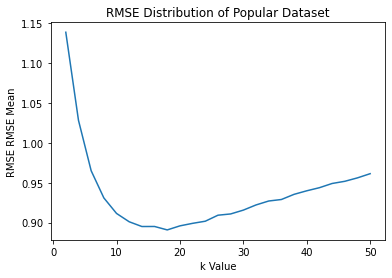

------------------------------------------------------------
Average MAE


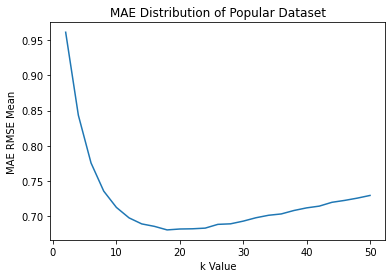

In [ ]:
freq = np.sum((df.pivot_table('rating', 'userId', 'movieId', fill_value=0))!=0, axis=0)
NMF_RMSE_popular, _ = cross_validation_NMF(ratings_data, freq=freq, data_filter='popular', title='Distribution of Popular Dataset', x_label='k Value', y_label='RMSE Mean')

In [ ]:
find_min_k_RMSE(NMF_RMSE_popular, list(range(2, 52, 2)))

(18, 0.8908713846988523)

UNPOPULAR

Average RMSE


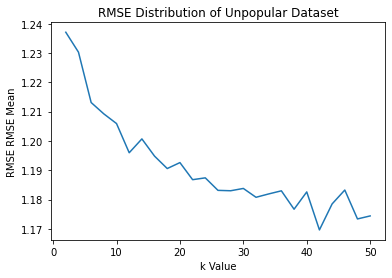

------------------------------------------------------------
Average MAE


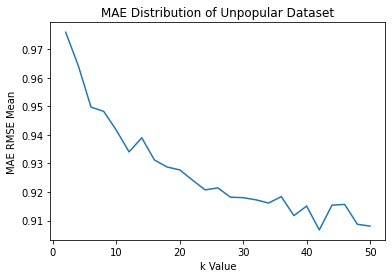

In [ ]:
NMF_RMSE_unpopular, _ = cross_validation_NMF(ratings_data, freq=freq, data_filter='unpopular', title='Distribution of Unpopular Dataset', x_label='k Value', y_label='RMSE Mean')

In [ ]:
find_min_k_RMSE(NMF_RMSE_unpopular, list(range(2, 52, 2)))

(42, 1.169644631192107)

HIGH VARIANCE

Average RMSE


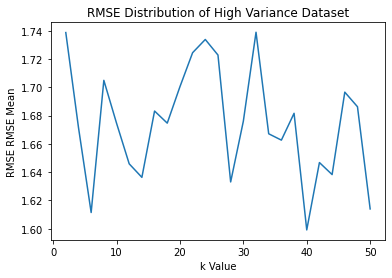

------------------------------------------------------------
Average MAE


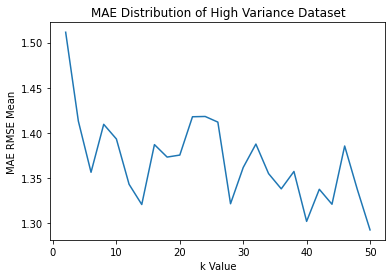

In [ ]:
high_var = np.var((df.pivot_table('rating', 'userId', 'movieId')), axis=0)
NMF_RMSE_high_var, _ = cross_validation_NMF(ratings_data, freq=freq, high_var = high_var, data_filter='high_variance', title='Distribution of High Variance Dataset', x_label='k Value', y_label='RMSE Mean')

In [ ]:
find_min_k_RMSE(NMF_RMSE_high_var, list(range(2, 52, 2)))

(40, 1.599174554698459)

## ROC CURVE FOR NMF


In [ ]:
def plot_roc_nmf(dataset, k, threshold, freq, high_var=None, data_filter='original'):
    nmf_model = NMF(n_factors=k, verbose=False)
    train, test = train_test_split(dataset, test_size=0.1)
    nmf_model.fit(train)
    if data_filter == 'original':
        test = test
    elif data_filter == 'popular' or data_filter == 'unpopular':
        test = process_movie(test, freq, data_filter=data_filter)
    else: # 'high_variance'
        test = process_movie(test, freq, high_var=high_var, data_filter=data_filter)
        print(len(test))
    prediction = nmf_model.test(test)
    label = []
    pred = []
    for i in range(len(prediction)):
        pred.append(prediction[i].est)
        if test[i][2] >= threshold:
            label.append(1)
        else:
            label.append(0)
    fpr, tpr, _ = roc_curve(label, pred)
    AUC = roc_auc_score(label, pred)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive')
    plt.ylabel('True Positive')
    plt.title('ROC Curve of Threshold {} and AUC {}'.format(threshold, AUC))
    plt.show()
    return fpr, tpr, AUC

In [ ]:
ratings_data = Dataset.load_from_df(df[['userId','movieId','rating']], Reader(rating_scale=(0.5, 5.5)))
freq = np.sum((df.pivot_table('rating', 'userId', 'movieId', fill_value=0))!=0, axis=0)
high_var = np.var((df.pivot_table('rating', 'userId', 'movieId')), axis=0)

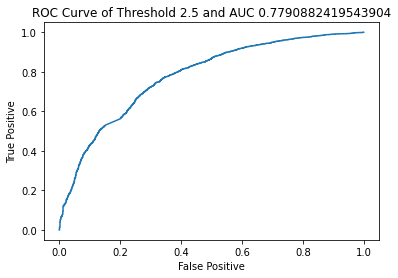

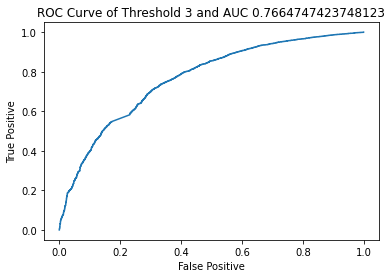

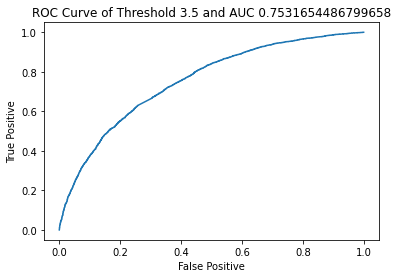

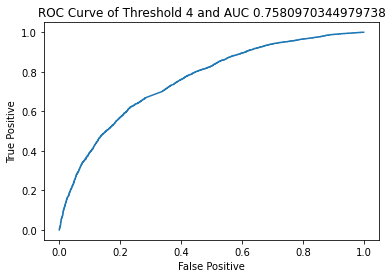

In [ ]:
thresholds = [2.5, 3, 3.5, 4]
nmf_fprs = []
nmf_tprs = []
nmf_AUCs = []
min_k_nmf = 16
for t in thresholds:
    nmf_fpr, nmf_tpr, nmf_AUC = plot_roc_nmf(ratings_data, min_k_nmf, t, freq=freq, high_var=high_var, data_filter="original")
    nmf_fprs.append(nmf_fpr)
    nmf_tprs.append(nmf_tpr)
    nmf_AUCs.append(nmf_AUC)

In [ ]:
def comparison_plot_nmf(fprs, tprs, AUCs, thresholds, title='Original'):
    for i in range(len(fprs)):
        plt.plot(fprs[i], tprs[i], label = 'ROC Curve of Threshold {} and AUC {:.5f}'.format(thresholds[i], AUCs[i]))
    plt.legend()
    plt.xlabel('False Positive')
    plt.ylabel('True Positive')
    plt.title('ROC Curve for Comparison with {} Dataset'.format(title))
    plt.show()

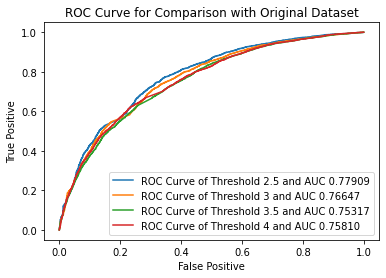

In [ ]:
comparison_plot_nmf(nmf_fprs, nmf_tprs, nmf_AUCs, thresholds)

# QUESTION 9

In [ ]:
genres_data = pd.read_csv("./Dataset/movies.csv")
nmf_model = NMF(n_factors=20, verbose=False)
train, test = train_test_split(ratings_data, test_size=0.1)
nmf_model.fit(train)
U = nmf_model.pu
V = nmf_model.qi

In [ ]:
print(V.shape)

(9355, 20)


In [ ]:
for col in range(V.shape[1]):
    print("\n")
    print("Column: " + str(col))
    print("--" * 20)
    curr_col = np.argsort(V[:, col])[::-1][:10]
    for genre in curr_col:
        print(genres_data["genres"][genre])



Column: 0
----------------------------------------
Adventure|Children
Crime|Thriller
Adventure|Animation|Children|Drama|Fantasy
Horror
Comedy|Romance
Adventure|Children|Fantasy|Sci-Fi
Drama
Drama
Drama|Film-Noir|Thriller
Drama


Column: 1
----------------------------------------
Children|Comedy
Comedy
Comedy|Drama|Romance
Comedy
Adventure|Drama|Mystery
Action|Documentary|Drama|Thriller
Action|Comedy
Western
Comedy|Romance
Drama


Column: 2
----------------------------------------
Drama
Drama
Comedy|Crime|Mystery|Thriller
Adventure|Fantasy
Action|Crime|Drama|Thriller
Comedy|Romance
Drama
Action|Crime|Thriller
Action|Crime|Thriller|Western
Drama|Thriller


Column: 3
----------------------------------------
Comedy|Romance
Drama
Action|Thriller
Drama
Drama|Mystery|Romance|Thriller
Drama|War
Crime|Drama
Action|Drama
Drama
Drama|Horror|Thriller


Column: 4
----------------------------------------
Action|Adventure|Comedy|Drama|War
Crime|Drama|Thriller
Comedy
Comedy|Thriller
Comedy
Comedy|Fa

# QUESTION 10

In [ ]:
def cross_validation_MF(training_input, freq=None, high_var=None, data_filter='original', title='None', x_label='None', y_label='None'):
    kfold_model = KFold(n_splits=10)
    RMSE = []
    MAE = []
    for n_factors in range(2, 52, 2):
        mf_model = SVD(n_factors=n_factors, verbose=False)
        rmse_temp = []
        mae_temp = []
        for training_data, val_data in kfold_model.split(training_input):
            mf_model.fit(training_data)
            if data_filter == 'original':
                processed_data = val_data
            elif data_filter == 'popular' or data_filter == 'unpopular':
                processed_data = process_movie(val_data, freq, data_filter=data_filter)
            else: # 'high_variance'
                processed_data = process_movie(val_data, freq, high_var=high_var, data_filter=data_filter)
            res = mf_model.test(processed_data)
            rmse_temp.append(accuracy.rmse(res, verbose=False))
            mae_temp.append(accuracy.mae(res, verbose=False))
        rmse_mean = np.mean(rmse_temp)
        mae_mean = np.mean(mae_temp)
        RMSE.append(rmse_mean)
        MAE.append(mae_mean)
    print("Average RMSE")
    plt.plot(np.arange(2, 52, 2), RMSE)
    plt.title("RMSE " + title)
    plt.xlabel(x_label)
    plt.ylabel("RMSE " + y_label)
    plt.show()
    print("---" * 20)
    print("Average MAE")
    plt.plot(np.arange(2, 52, 2), MAE)
    plt.title("MAE " + title)
    plt.xlabel(x_label)
    plt.ylabel("MAE " + y_label)
    plt.show()
    return RMSE, MAE

Average RMSE


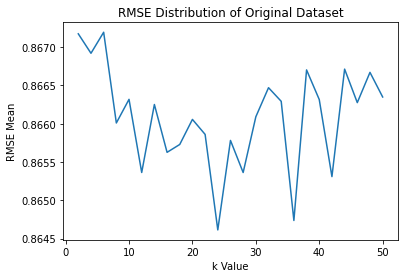

------------------------------------------------------------
Average MAE


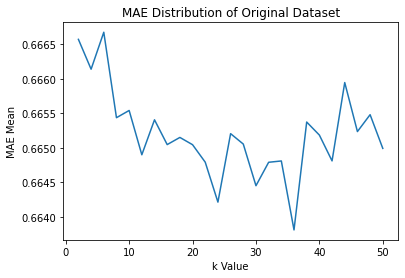

In [ ]:
ratings_data = Dataset.load_from_df(df[['userId','movieId','rating']], Reader(rating_scale=(0.5, 5.5)))
MF_RMSE_original, MF_MAE_original = cross_validation_MF(ratings_data, data_filter='original', title='Distribution of Original Dataset', x_label='k Value', y_label='Mean')

In [ ]:
optimal_k, rmse = find_min_k_RMSE(MF_RMSE_original, list(range(2, 52, 2)))
print("RMSE = {:.4f} and k = {}".format(rmse, optimal_k))

RMSE = 0.8646 and k = 24


In [ ]:
optimal_k, mae = find_min_k_MAE(MF_MAE_original, list(range(2, 52, 2)))
print("MAE = {:.4f} and k = {}".format(mae, optimal_k))

MAE = 0.6638 and k = 36


POPULAR

Average RMSE


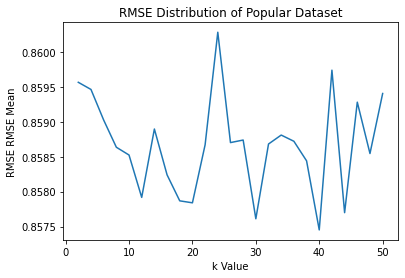

------------------------------------------------------------
Average MAE


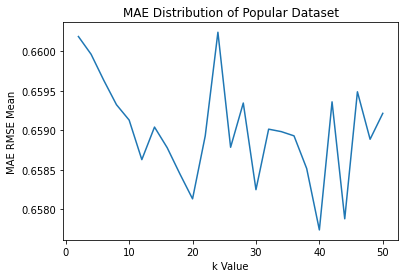

In [ ]:
freq = np.sum((df.pivot_table('rating', 'userId', 'movieId', fill_value=0))!=0, axis=0)
MF_RMSE_popular, _ = cross_validation_MF(ratings_data, freq=freq, data_filter='popular', title='Distribution of Popular Dataset', x_label='k Value', y_label='RMSE Mean')

In [ ]:
find_min_k_RMSE(MF_RMSE_popular, list(range(2, 52, 2)))

(40, 0.8574520462577399)

UNPOPULAR

Average RMSE


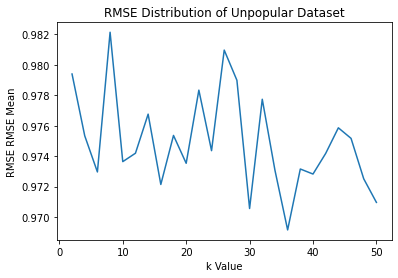

------------------------------------------------------------
Average MAE


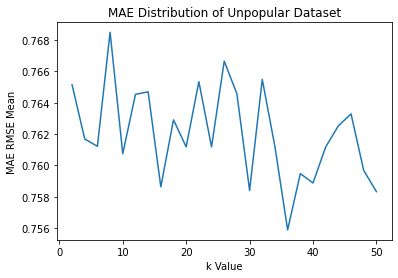

In [ ]:
MF_RMSE_unpopular, _ = cross_validation_MF(ratings_data, freq=freq, data_filter='unpopular', title='Distribution of Unpopular Dataset', x_label='k Value', y_label='RMSE Mean')

In [ ]:
find_min_k_RMSE(MF_RMSE_unpopular, list(range(2, 52, 2)))

(36, 0.9691540532405322)

HIGH VARIANCE

Average RMSE


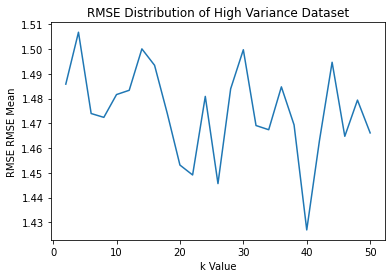

------------------------------------------------------------
Average MAE


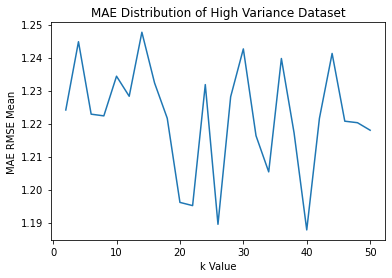

In [ ]:
high_var = np.var((df.pivot_table('rating', 'userId', 'movieId')), axis=0)
MF_RMSE_high_var, _ = cross_validation_MF(ratings_data, freq=freq, high_var = high_var, data_filter='high_variance', title='Distribution of High Variance Dataset', x_label='k Value', y_label='RMSE Mean')

In [ ]:
find_min_k_RMSE(MF_RMSE_high_var, list(range(2, 52, 2)))

(40, 1.4269720812126507)

## ROC CURVE FOR MF


In [ ]:
def plot_roc_mf(dataset, k, threshold):
    mf_model = SVD(n_factors=k, verbose=False)
    train, test = train_test_split(dataset, test_size=0.1)
    mf_model.fit(train)
    prediction = mf_model.test(test)
    label = []
    pred = []
    for i in range(len(prediction)):
        pred.append(prediction[i].est)
        if test[i][2] >= threshold:
            label.append(1)
        else:
            label.append(0)
    fpr, tpr, _ = roc_curve(label, pred)
    AUC = roc_auc_score(label, pred)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive')
    plt.ylabel('True Positive')
    plt.title('ROC Curve of Threshold {} and AUC {:.2f}'.format(threshold, AUC))
    plt.show()
    return fpr, tpr, AUC

In [ ]:
ratings_data = Dataset.load_from_df(df[['userId','movieId','rating']], Reader(rating_scale=(0.5, 5.5)))

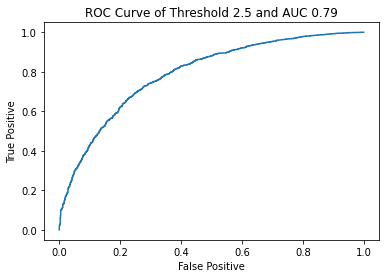

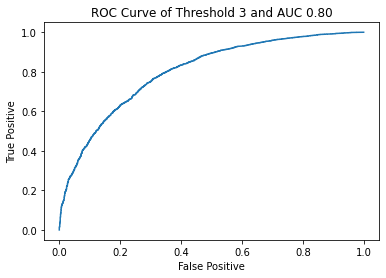

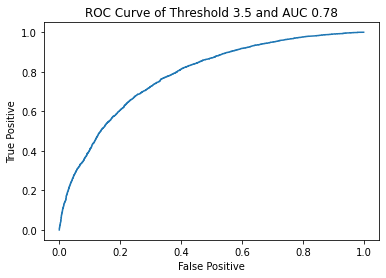

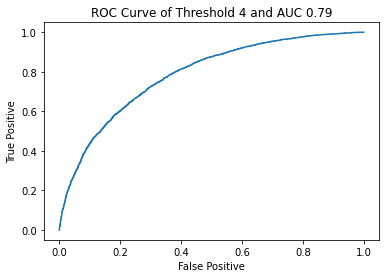

In [ ]:
thresholds = [2.5, 3, 3.5, 4]
mf_fprs = []
mf_tprs = []
mf_AUCs = []
min_k_mf = 24
for t in thresholds:
    mf_fpr, mf_tpr, mf_AUC = plot_roc_mf(ratings_data, min_k_mf, t)
    mf_fprs.append(mf_fpr)
    mf_tprs.append(mf_tpr)
    mf_AUCs.append(mf_AUC)

In [ ]:
def comparison_plot_mf(fprs, tprs, AUCs, thresholds):
    for i in range(len(fprs)):
        plt.plot(fprs[i], tprs[i], label = 'ROC Curve of Threshold {} and AUC {:.4f}'.format(thresholds[i], AUCs[i]))
    plt.legend()
    plt.xlabel('False Positive')
    plt.ylabel('True Positive')
    plt.title('ROC Curve for Comparison')
    plt.show()

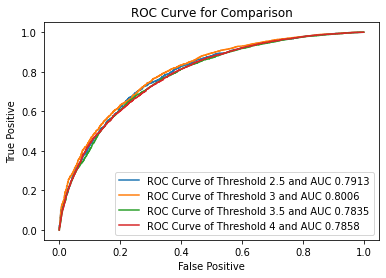

In [ ]:
comparison_plot_mf(mf_fprs, mf_tprs, mf_AUCs, thresholds)

# NAIVE COLLABORATIVE FILTERING

QUESTION 11

In [ ]:
def naive_collaborative(training_input, freq=None, high_var=None, data_filter='original'):
    kfold_model = KFold(n_splits=10)
    RMSE = []
    for training_data, val_data in kfold_model.split(training_input):
        if data_filter == 'original':
            processed_data = val_data
        elif data_filter == 'popular' or data_filter == 'unpopular':
            processed_data = process_movie(val_data, freq, data_filter=data_filter)
        else: # 'high_variance'
            processed_data = process_movie(val_data, freq, high_var=high_var, data_filter=data_filter)
        rmse = 0
        predicted_ratings = [user_rating_dict[u] for u, m, r in processed_data]
        true_ratings = [r for u, m, r in processed_data]
        rmse = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))
        RMSE.append(rmse)    
    return np.sum(RMSE) / 10.0

In [ ]:
user_ID = df["userId"].values
rating = df["rating"].values
user_rating_dict = collections.defaultdict(list)
for i, user in enumerate(user_ID):
    user_rating_dict[user].append(rating[i])
for key, val in user_rating_dict.items():
    user_rating_dict[key] = np.mean(val)

In [ ]:
ratings_data = Dataset.load_from_df(df[['userId','movieId','rating']], Reader(rating_scale=(0.5, 5)))
RMSE_original = naive_collaborative(ratings_data, data_filter='original')
print(RMSE_original)

0.9347050632833586


POPULAR

In [ ]:
freq = np.sum((df.pivot_table('rating', 'userId', 'movieId', fill_value=0))!=0, axis=0)
RMSE_popular = naive_collaborative(ratings_data, freq=freq, data_filter='popular')
print(RMSE_popular)

0.9322979395325526


UNPOPULAR

In [ ]:
RMSE_unpopular = naive_collaborative(ratings_data, freq=freq, data_filter='unpopular')
print(RMSE_unpopular)

0.9712463617222215


In [ ]:
high_var = np.var((df.pivot_table('rating', 'userId', 'movieId')), axis=0)
RMSE_high_var = naive_collaborative(ratings_data, freq=freq, high_var=high_var, data_filter='high_variance')
print(RMSE_high_var)

1.457187938235685


# QUESTION 12

In [ ]:
def plot_comparison_ROC(dataset, knn_k, nmf_k, mf_k, threshold):
    fprs = list()
    tprs = list()
    train, test = train_test_split(dataset, test_size=0.1)
    knn_model = KNNWithMeans(k=knn_k, sim_options={'name': 'pearson'}, verbose=False)
    knn_model.fit(train)
    prediction_knn = knn_model.test(test)
    label = []
    pred_knn = []
    for i in range(len(prediction_knn)):
        pred_knn.append(prediction_knn[i].est)
        if test[i][2] >= threshold:
            label.append(1)
        else:
            label.append(0)
    fpr_knn, tpr_knn, _ = roc_curve(label, pred_knn)
    AUC_knn = roc_auc_score(label, pred_knn)
    fprs.append(fpr_knn)
    tprs.append(tpr_knn)

    nmf_model = NMF(n_factors=nmf_k, verbose=False)
    nmf_model.fit(train)
    pred_nmf = []
    prediction_nmf = nmf_model.test(test)
    for i in range(len(prediction_nmf)):
        pred_nmf.append(prediction_nmf[i].est)
    fpr_nmf, tpr_nmf, _ = roc_curve(label, pred_nmf)
    AUC_nmf = roc_auc_score(label, pred_nmf)
    fprs.append(fpr_nmf)
    tprs.append(tpr_nmf)

    mf_model = SVD(n_factors=mf_k, verbose=False)
    mf_model.fit(train)
    prediction_mf = mf_model.test(test)
    pred_mf = []
    for i in range(len(prediction_mf)):
        pred_mf.append(prediction_mf[i].est)
    fpr_mf, tpr_mf, _ = roc_curve(label, pred_mf)
    AUC_mf = roc_auc_score(label, pred_mf)
    fprs.append(fpr_mf)
    tprs.append(tpr_mf)
    for i in range(len(fprs)):
        if i == 0:
            plt.plot(fprs[i], tprs[i], label = 'KNN: AUC {:.4f}'.format(AUC_knn))
        elif i == 1:
            plt.plot(fprs[i], tprs[i], label = 'NMF: AUC {:.4f}'.format(AUC_nmf))
        elif i == 2:
            plt.plot(fprs[i], tprs[i], label = 'MF: AUC {:.4f}'.format(AUC_mf))
    plt.legend()
    plt.xlabel('False Positive')
    plt.ylabel('True Positive')
    plt.title('ROC Curve for Comparison')
    plt.show()

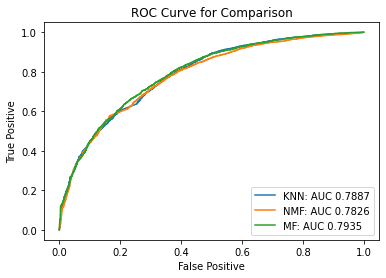

In [ ]:
ratings_data = Dataset.load_from_df(df[['userId','movieId','rating']], Reader(rating_scale=(0.5, 5.5)))
plot_comparison_ROC(ratings_data, knn_k = 20, nmf_k=16, mf_k=24, threshold=3)

# QUESTION 14

In [ ]:
def drop_user(dataset, t, threshold):
  freq = {}
  rate = {}
  for user, _, r in dataset:
    if user not in freq:
      freq[user] = 0
    freq[user] += 1
    if user not in rate:
      rate[user] = 0
    if r >= threshold:
      rate[user] += 1
  res = []
  for user, i, r in dataset:
    if freq[user] >= t and rate[user] > 0:
      res.append((user, i, r))
  return res

In [ ]:
def relevant(rate, t, threshold):
  rate.sort(key=lambda x: x[0], reverse=True)
  item = 0
  for i in range(t):
    if rate[i][1] >= threshold:
      item += 1
  rel = sum((true_r >= threshold) for (_, true_r) in rate)
  return item, rel

def precisionNrecall(pred, t, threshold=3):
  pred_true = collections.defaultdict(list)
  for u, _, r, est, _ in pred:
    pred_true[u].append((est, r))
  precisions = {}
  recalls = {}
  for user, rate in pred_true.items():
    item, rel = relevant(rate, t, threshold)
    precisions[user] = item / t
    recalls[user] = item / rel
  return precisions, recalls

In [ ]:
def comparePR(dataset, t, threshold, min_k, model_prec, model_rec, model='KNN'):
  prec = []
  rec = []
  kfold_model = KFold(n_splits=10)
  for training_data, val_data in kfold_model.split(dataset):
    if model == 'KNN':
      model = KNNWithMeans(k=min_k, sim_options={'name': 'pearson'}, verbose=False)
    if model == 'NMF':
      model = NMF(n_factors=min_k, biased=False, verbose=False)
    if model == 'MF':
      model = SVD(n_factors=min_k, biased=True, verbose=False)
    model.fit(training_data)
    dropped_data = drop_user(val_data, t, threshold)
    pred = model.test(dropped_data)
    precisions, recalls = precisionNrecall(pred, t, threshold)
    precision_mean = np.sum(prec for prec in precisions.values()) / len(precisions)
    recall_mean = np.sum(rec for rec in recalls.values()) / len(recalls)
    prec.append(precision_mean)
    rec.append(recall_mean)
  model_prec.append(np.mean(prec))
  model_rec.append(np.mean(rec))
  # return model_prec, model_rec
def drawPR(prec, rec, t_data, title):
    plt.gcf().clear()
    plt.figure(figsize=(12,24))
    plt.subplot(3, 1, 1)
    plt.plot(t_data, prec)
    plt.xlabel('t')
    plt.ylabel('Precision')
    plt.title('Precision of {} Model'.format(title))
    plt.subplot(3, 1, 2)
    plt.plot(t_data, rec)
    plt.xlabel('t')
    plt.ylabel('Recall')
    plt.title('Recall of {} Model'.format(title))
    plt.subplot(3, 1, 3)
    plt.scatter(prec, rec)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Precision vs Recall of {} Model'.format(title))
    plt.show()

In [ ]:
t_data = []
for t in range(1, 26):
  t_data.append(t)
threshold = 3

KNN PRECISION AND RECALL

In [ ]:
knn_prec = []
knn_rec = []
knn_min_k = 20
for t in t_data:
  comparePR(ratings_data, t, threshold, knn_min_k, knn_prec, knn_rec, model='KNN')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


<Figure size 432x288 with 0 Axes>

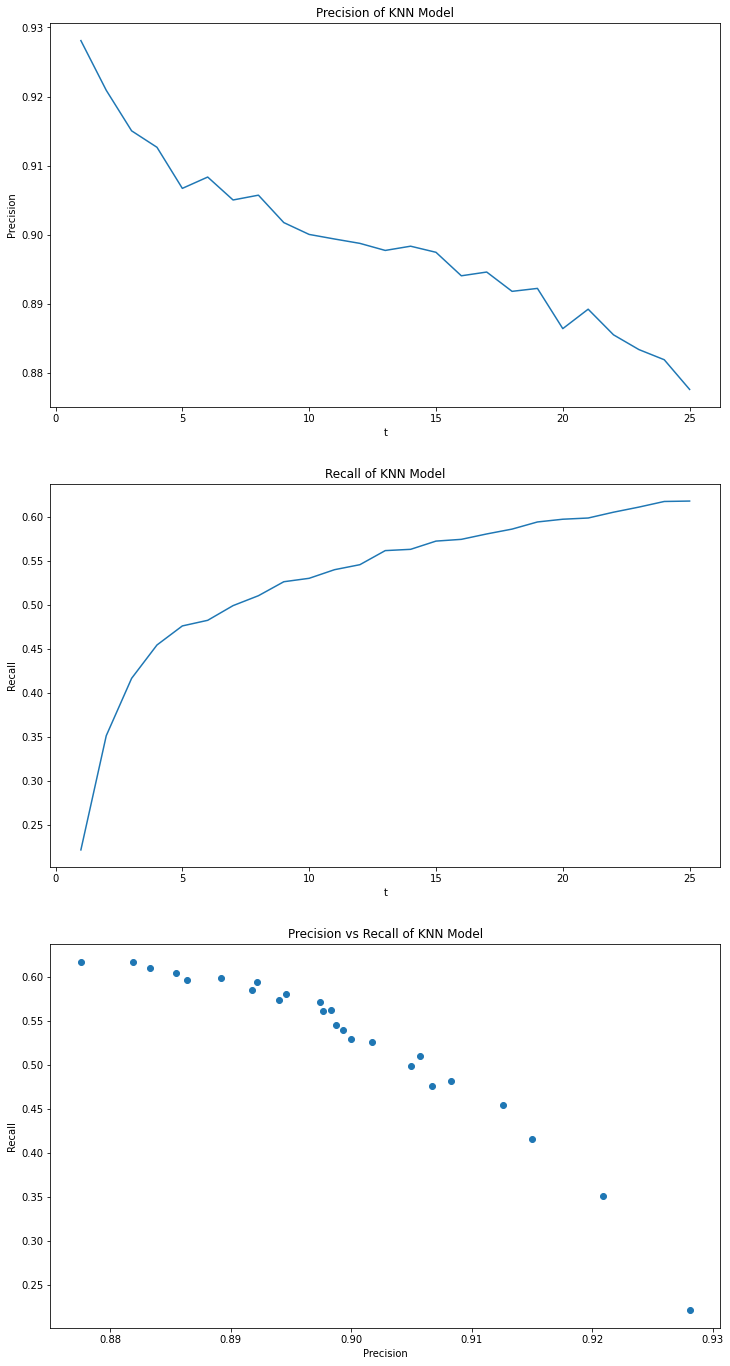

In [ ]:
drawPR(knn_prec, knn_rec, t_data,'KNN')

NMF PRECISION AND RECALL

In [ ]:
nmf_prec = []
nmf_rec = []
nmf_min_k = 16
for t in t_data:
  comparePR(ratings_data, t, threshold, nmf_min_k, nmf_prec, nmf_rec, model='NMF')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


<Figure size 432x288 with 0 Axes>

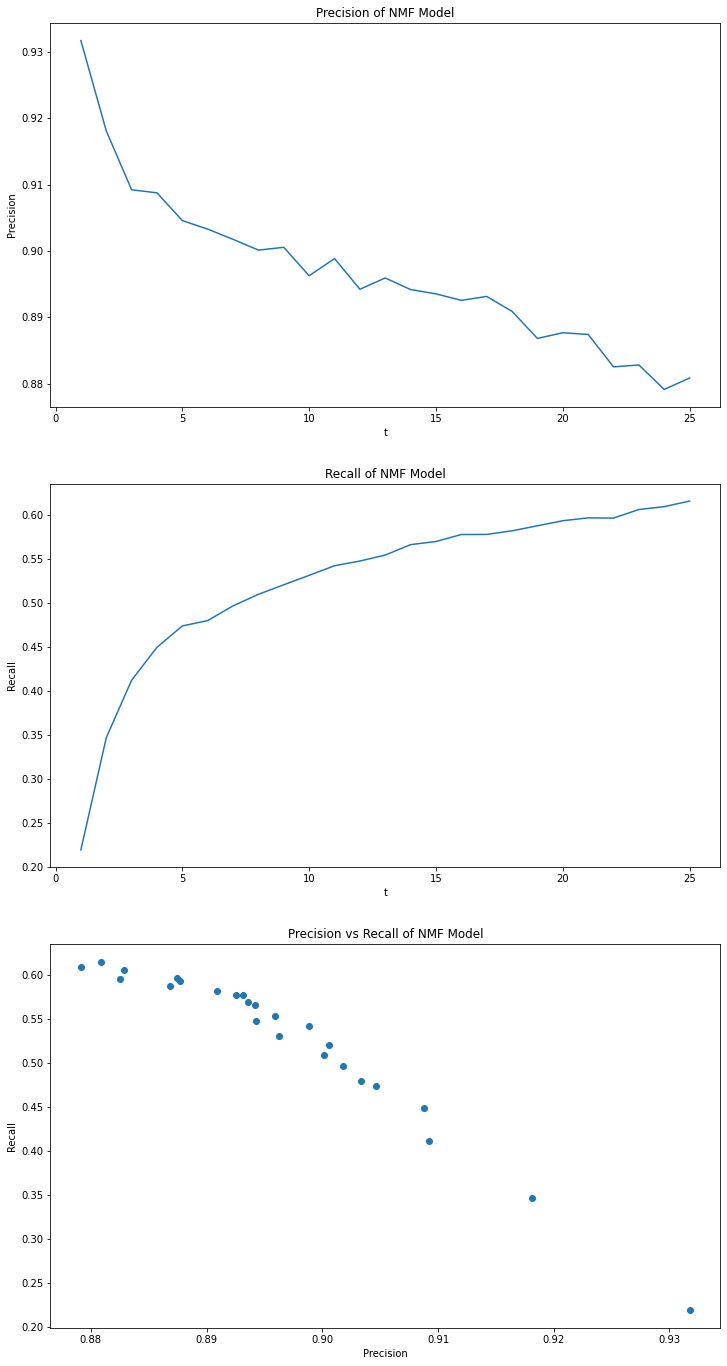

In [ ]:
drawPR(nmf_prec, nmf_rec, t_data,'NMF')

MF PRECISION AND RECALL

In [ ]:
mf_prec = []
mf_rec = []
mf_min_k = 24
for t in t_data:
  comparePR(ratings_data, t, threshold, mf_min_k, mf_prec, mf_rec, model='MF')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


<Figure size 432x288 with 0 Axes>

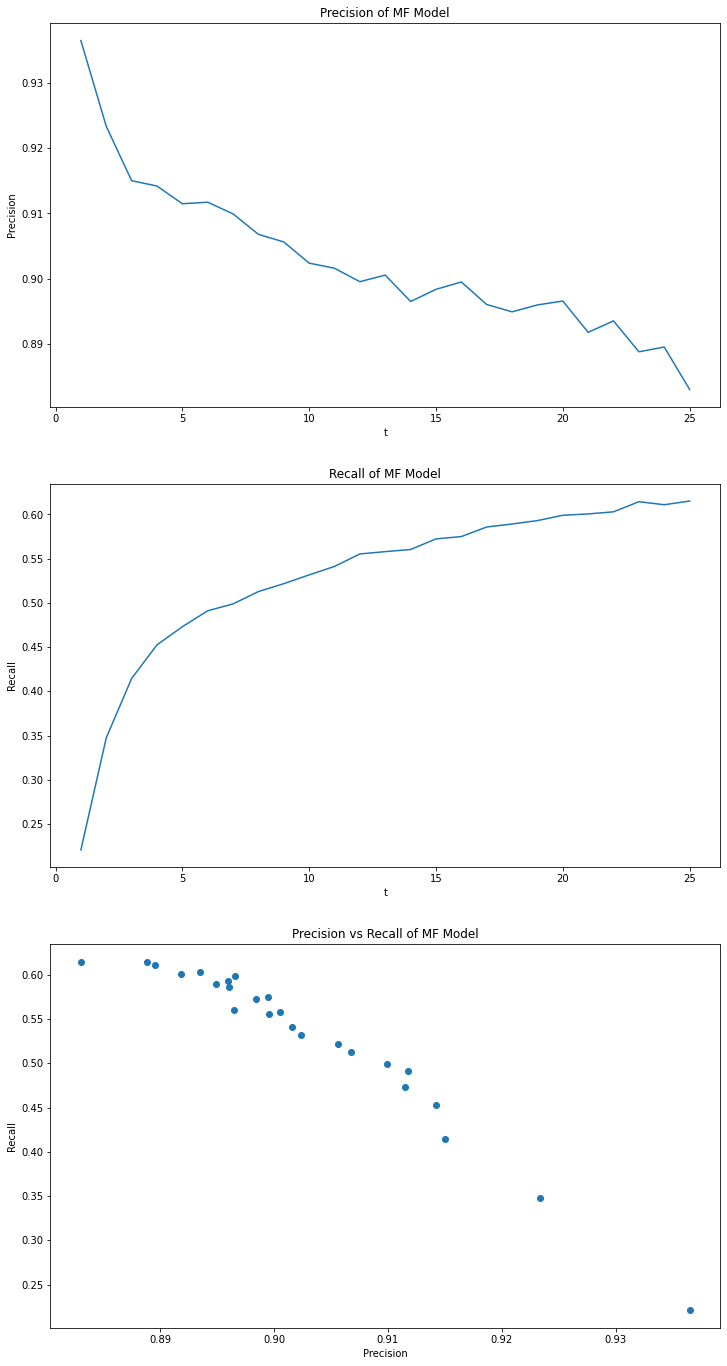

In [ ]:
drawPR(mf_prec, mf_rec, t_data,'MF')

COMPARISON

<Figure size 432x288 with 0 Axes>

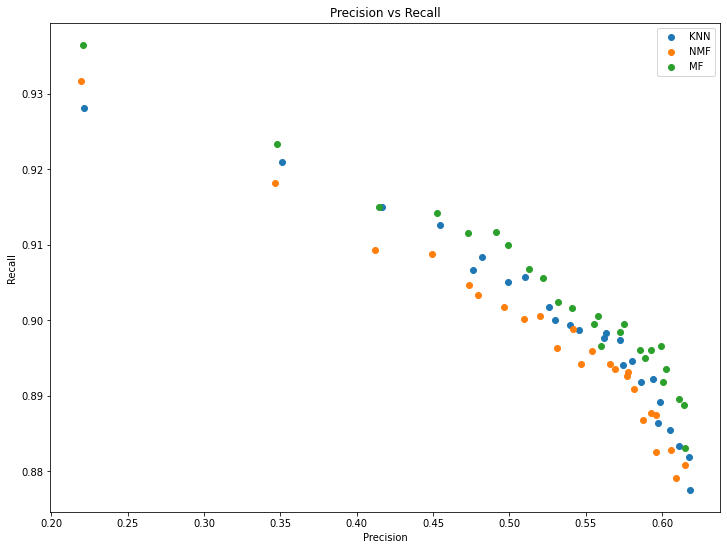

In [ ]:
plt.gcf().clear()
plt.figure(figsize=(12,9))
plt.scatter(knn_rec, knn_prec, label='KNN')
plt.scatter(nmf_rec, nmf_prec, label='NMF')
plt.scatter(mf_rec, mf_prec, label='MF')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision vs Recall')
plt.legend(loc="upper right")
plt.show()